## <u> 1. Movement with constant velocity </u>

State vector <b>x</b> is a position of sth travelling with a constant velocity <b>v</b>. <br\>
Measurement is the very same position <b>z</b>.

In [1]:
import numpy

### Parameters

In [2]:
N = 10
dt = 1.
v = -10.

### True trajectory

In [3]:
x0 = 100.
xtrue = numpy.empty((N,))
xtrue[0] = x0
for i in range(1,N):
    xtrue[i] = xtrue[i-1] + v*dt
print(xtrue)

[ 100.   90.   80.   70.   60.   50.   40.   30.   20.   10.]


### Measured trajectory

In [4]:
xmeas = numpy.empty((N,))
print(xmeas)
sigma = 10
for i in range(0,N):
    xmeas[i] = numpy.random.normal(xtrue[i], sigma)
print(xmeas)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 111.20949542   77.22084639   75.56482159   79.99786467   65.87730803
   68.63239005   50.81715565   20.6958633    21.6428296    24.13084612]


## Kalman

In [5]:
xkal = numpy.empty((N,))
xpredict = numpy.empty((N,))
p = numpy.empty((N,))
K = numpy.empty((N,))
# initial position
xpredict[0] = xkal[0] = xmeas[0]
# initial variance on prediction
p[0] = 20
# measurement error
r = sigma^2

for i in range(1,N):
    # prediction: recursive formula
    xpredict[i] = xkal[i-1] + v*dt
    p[i] = p[i-1]
    K[i] = p[i]/(p[i]+r)
    xkal[i] = xpredict[i] + K[i]*(xmeas[i] - xpredict[i])
    p[i] = (1-K[i]) * p[i]


### Plot results

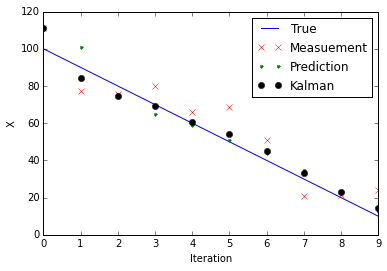

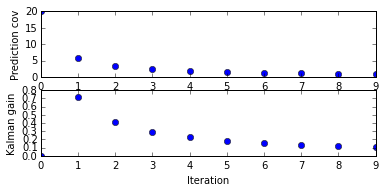

In [6]:
%matplotlib inline
import matplotlib.pyplot as plot
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas, 'rx', label = 'Measuement')
plot.plot(xpredict, 'g.',  label = 'Prediction')
plot.plot(xkal, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.legend()
plot.show()
plot.subplot(3,1,1)
plot.plot(p,'o')
plot.ylabel('Prediction cov')
plot.subplot(3,1,2)
plot.plot(K,'o')
plot.ylabel('Kalman gain')
plot.xlabel('Iteration')
plot.show()


### <u>2. Same problem but with unknown velocity<u\> 

In [7]:
xpredict2 = numpy.matrix (numpy.linspace(0,10,N*2).reshape((2, N)))
xkal2 = numpy.matrix (numpy.linspace(0,10,N*2).reshape((2, N)))
# initial position
xpredict2[:,0] = xkal2[:,0] = numpy.array ( [[xmeas[0]], [numpy.random.normal(v,1.5) ] ])
# initial variance on prediction
p2 = numpy.matrix ( [[20, 0],
                    [0, 20]] )
# measurement error
r = numpy.matrix([[sigma^2]])

# prediction matrix
A = numpy.matrix ( [[1, dt],
                    [0, 1]] )
# transformation matrix (from measurement to state vector)
H = numpy.matrix ( [[1 , 0]] )

for i in range(1,N):
    # prediction: recursive formula
    xpredict2[:,i] = numpy.array ( [[ xkal2[0,i-1] + xkal2[1,i-1]*dt], [xkal2[1,i-1] ]] )
    p2 = A*p2*A.T
    K2 = p2*H.T/(H*p2*H.T+r)
    xkal2[:,i] = xpredict2[:,i] + K2*(xmeas[i] - H*xpredict2[:,i])
    p2 = (numpy.identity(2)-K2) * p2

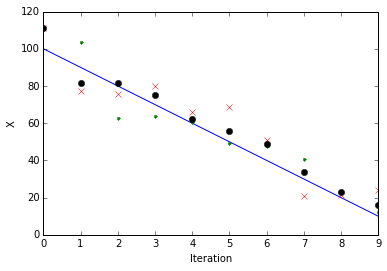

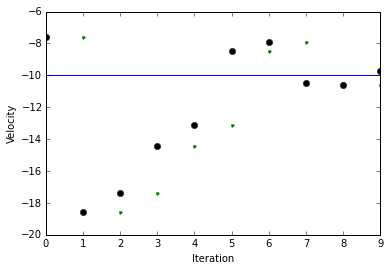

In [8]:
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas, 'rx', label = 'Measuement')
plot.plot(xpredict2[0].T, 'g.',  label = 'Prediction')
plot.plot(xkal2[0].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.show()

plot.axhline(v)
plot.plot(xpredict2[1].T, 'g.',  label = 'Prediction')
plot.plot(xkal2[1].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('Velocity')
plot.show()

### <u>3. Same problem but with unknown velocity that is also measured<u\> 

#### In principle should be better than 2. - why isn't ?? Additional measurement (on x_velocity) should improve kalman

In [9]:
xmeas3 = numpy.matrix (numpy.linspace(0,10,N*2).reshape((2, N)))
sigma3 = 1
for i in range(0,N):
    xmeas3[0,i] = numpy.random.normal(xtrue[i], sigma)
    xmeas3[1,i] = numpy.random.normal(v, sigma3)
print(xmeas3.T)

[[ 106.5691057    -9.99665667]
 [  73.31172794   -8.87585379]
 [  62.63017856  -10.15494109]
 [  90.52327536   -8.53567726]
 [  42.40358256  -10.69057017]
 [  74.05425854   -8.2313645 ]
 [  22.77951981  -11.18514607]
 [  32.91373662  -11.79571145]
 [  21.13352033  -10.79564491]
 [  23.52432576  -10.62110082]]


In [10]:
xpredict3 = numpy.matrix (numpy.linspace(0,10,N*2).reshape((2, N)))
xkal3 = numpy.matrix (numpy.linspace(0,10,N*2).reshape((2, N)))
# initial position
xpredict3[:,0] = xkal3[:,0] = numpy.array ( [[xmeas3[0,0]], [xmeas3[1,0]] ] )
# initial variance on prediction
p2 = numpy.matrix ( [[20, 0],
                    [0, 20]] )
# measurement error
r3 = numpy.matrix([[0.001*sigma*sigma, 0],
                 [0  , 0.001*sigma3*sigma3]])

# prediction matrix
A = numpy.matrix ( [[1, dt],
                    [0, 1]] )
# transformation matrix (from measurement to state vector)
H3 = numpy.matrix ( [[1 , 0],
                   [0, 1]] )

for i in range(1,N):
    # prediction: recursive formula
    xpredict3[:,i] = numpy.array ( [[ xkal3[0,i-1] + xkal3[1,i-1]*dt], [xkal3[1,i-1] ]] )
    print(xpredict3[:,i].T)
    p2 = A*p2*A.T
    K2 = p2*H3.T/(H3*p2*H3.T+r3)
    xkal3[:,i] = xpredict3[:,i] + K2*(xmeas3[:,i] - H3*xpredict3[:,i])
    p2 = (numpy.identity(2)-K2) * p2

[[ 96.57244903  -9.99665667]]
[[ 42.3539067  -32.13663091]]
[[ 94.75462578  10.12242997]]
[[ 59.10053047 -12.76656066]]
[[ 17.08845545 -27.38748347]]
[[ 141.93829202   48.73424687]]
[[-167.49109969 -130.34429296]]
[[ 340.06472024  188.60866858]]
[[-508.00355946 -329.72731987]]


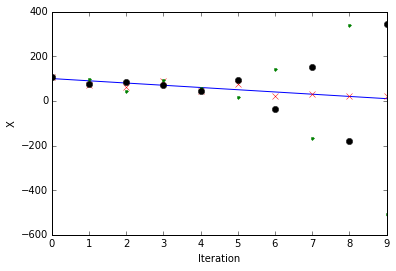

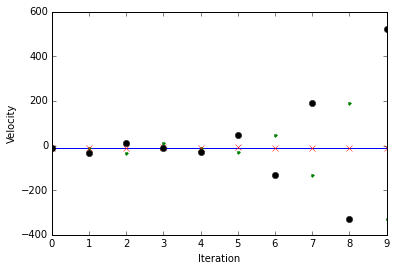

In [11]:
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas3[0].T, 'rx', label = 'Measuement')
plot.plot(xpredict3[0].T, 'g.',  label = 'Prediction')
plot.plot(xkal3[0].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.show()

plot.axhline(v)
plot.plot(xpredict3[1].T, 'g.',  label = 'Prediction')
plot.plot(xmeas3[1].T, 'rx', label = 'Measuement')
plot.plot(xkal3[1].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('Velocity')
plot.show()